# Module 4 Project: Financial Instrument Time Series Analysis - Non-Techincal Notebook
## Andrew Cole

## 1) Import Necessary Libraries

The main objective here is to provide the prospective stakeholder, a small-market wealth management advisory company, with statistical insight on past and future performance of potential investments. A financial vehicle, the XLV Healthcare mutual fund (ticker symbol: XLV), was selected for further analysis. 

A full Time Series analysis is conducted to look at the historic performance of the XLV as well as to forecast it's movement into the future. By taking in the historic information and movement of the closing prices of the XLV dating back 21 years to the end of 1998, we can look at past movements combined with TS modeling to create an accurate and confident projection of future prices. Multiple time series models with varying parameters were tested and compared to each other. After these comparisons a single model was selected and then the XLV data was fit to the selected model for forecasting of the future XLV closing prices. 

In [30]:
# Here we are importing the necessary Python libraries which we will use to gather necessary data, perform operations and transformations of the data,
# create visualizations, and model the different Time Series

import ticker_cleaner
import stationarity_check
import future_dates
import Auto_ARIMA

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as TS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2) Assemble Historical Data & Visualize 

The first thing we will do is gather the necessary historic financial information for the XLV mutual fund. Data was collected from Yahoo Finance. The Data will date back to December of 1998 and continue until present day. Once we have the necessary information we will re-group the data into monthly averages of the closing price. These monthly averages will then be visualized in a graph which will show us the historic movement of average monthly closing prices of the XLV fund.

In [2]:
# Using the Helper.py module to gather the XLV Yahoo Finance data and transform it into a DataFrame with operable features. 
# This is the basis for all operations completed on XLV data. 
# The output is a snapshot of the first five financial record entries (monthly average closing prices) as well as the five most recent.

xlv_monthly_mean = ticker_cleaner.yahoo_finance_clean('XLV')
xlv_monthly_mean

,Close
Date,
2020-01-01,101.848000
2019-12-01,100.354762
2019-11-01,95.596500
2019-10-01,90.148696
2019-09-01,89.694500
...,...
1999-04-01,21.752857
1999-03-01,20.773913
1999-02-01,20.173684


Below we can visualize the movement of these closing prices over time. We see that there is a very large increase (almost 450%) since the fund's first input close price. We notice that there is an upwards trend, so we will investigate further as to what is going on over time with the closing price.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


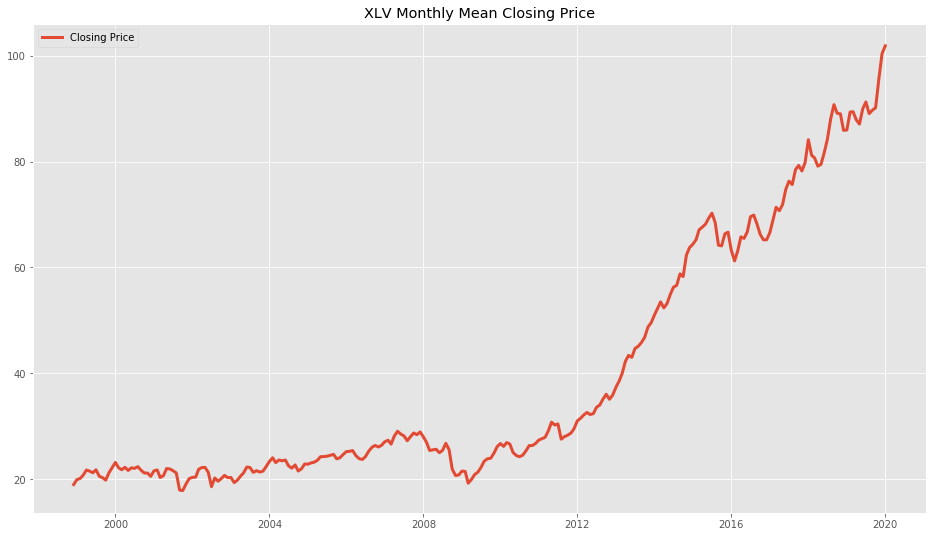

<Figure size 432x288 with 0 Axes>

In [3]:
warnings.filterwarnings(action='always')
plt.style.use('ggplot')
fig = plt.figure(figsize = (16,9))
plt.plot(xlv_monthly_mean, linewidth = 3, label = 'Closing Price')
plt.title('XLV Monthly Mean Closing Price')
plt.legend()
plt.show();
plt.savefig('XLV_beginning_close_price')

## 3) Decomposing the Fund

We will now decompose the XLV's movement of closing price to check for trends, seasonality, and residual distributions. Most Time Series models operate under the assumption that the properties are stationary (constant) over time. Basically, the mean and variance of the series should not actually be a function of time. First we will perform a log transformation to make the series more 'uniform' over time. This log transformation will not make it stationary but it will make it more linear. We then perform a decomposition function to separate trend, seasonality, and residual distributions from the XLV movements to get a better understanding of what is going on. 

In [4]:
# We are performing a log transformation and then separating the components after the decomposition process is performed. 
# The individual components are visualized below.
decomposition = seasonal_decompose(np.log(xlv_monthly_mean))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

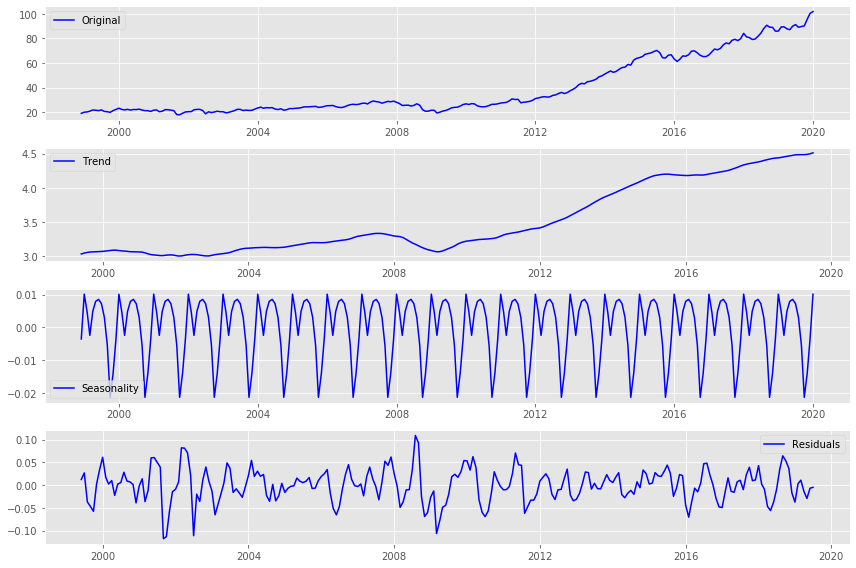

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(xlv_monthly_mean, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

We can see that there is definitely an upwards trend over time, which means we will need to conduct further testing to see if the series is in fact stationary. We also see very repetitive seasonality. The very large minimums are always followed by a peak, which represents the December to January swings in financial movements. This is nothing to be alarmed over, rather we can confirm that there is definitely seasonality present, which we will account for when modeling the TS. We also see that the residuals are centered around 0 mean with general homoscedasticity, which is a good thing for our model. 

## 4) Stationarity Check

Because we know that there is a significant upwards trend, we want to remove those trends to enforce stationarity of the series and then test to confirm. We first take a 1 period difference of every observation at a particular time instant with that at it's previous instant. This will improve stationarity. To confirm that the series is, in fact, stationary, we will perform a Dickey-Fuller statistical test. In a Dickey-Fuller (DF), the null hypothesis is that the series is **not** stationary. It will output a p-value test-statistic which we will need to be below 0.05 for us to safely reject the null hypothesis.


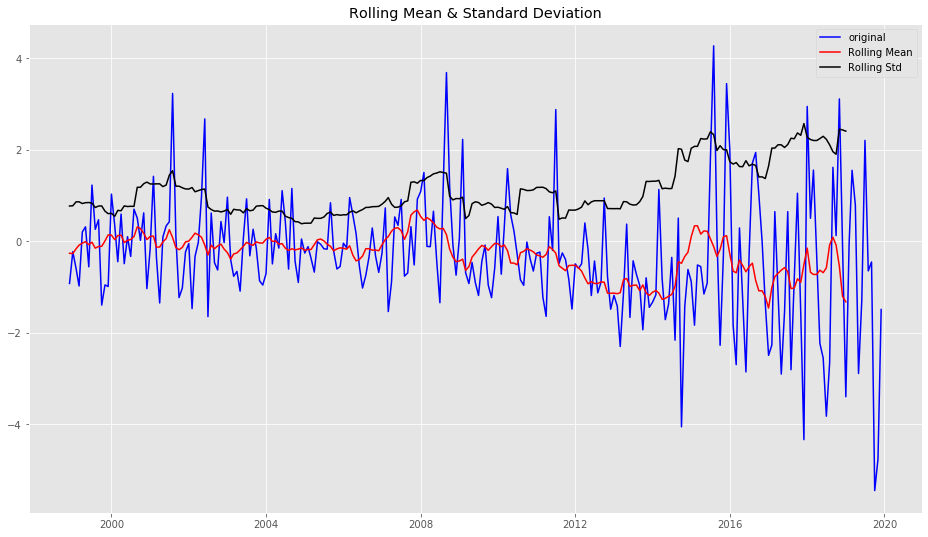

Results of Dickey-Fuller Test
Test Statistic                -1.188285e+01
p-value                        6.119892e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [6]:
xlv_differenced_mean = xlv_monthly_mean.diff(periods = 1).dropna()
stationarity_check.stationarity_check(xlv_differenced_mean.Close)

We first notice that the mean generally has variance centered around 0, a good sign for stationarity. Next, we see that the standard deviation is not quite centered around the mean, however, the Dickey-Fuller test resulted in a p-value = 6.10e-22, which is extremely small. Due to such a small p-value, we can ignore the standard deviation's slight waverance from 0 and conclude that we **reject** the null hypothesis. The Time Series is stationary and can now begin to be modeled.

## 5) Model Optimization

Because we know that the series is now stationary, we need to gather the proper parameters for optimizing a best performing model. We will perform an Autocorrelation (ACF) function to test for Moving Average parameters. These will tell a story about trend & seasonality by seeing if there is autocorrelation among the series and its past values. We will then check the Partial Auto-Correlation Function (PACF) to get Autoregressive Model parameters. These parameters will represent partial correlation of a series with its own lagged values, while controlling for values of the TS at all shorter lags (the ACF does not do this). This will give us a summary of the relation between the TS element and it's previous position while removing all observations in between.

#### ACF:

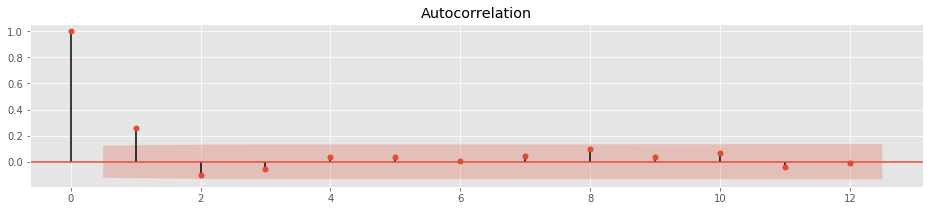

In [7]:
fig, ax = plt.subplots(figsize = (16,3))
plot_acf(xlv_differenced_mean, ax = ax, lags = 12);

#### PACF:

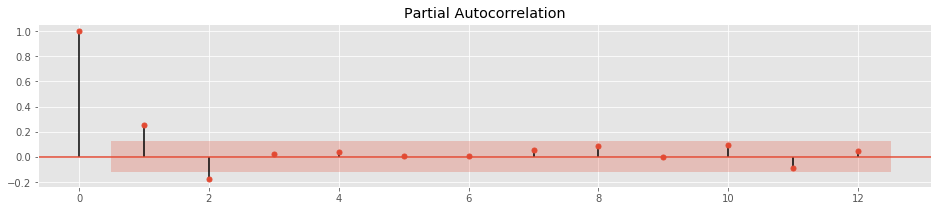

In [8]:
fig, ax = plt.subplots(figsize = (16,3))
plot_pacf(xlv_differenced_mean, ax = ax, lags = 12);

For the ACF-Moving Average parameters, we see that only the observation at the first lag is outside the confidence interval (the red bar area) and therefore worth incorporating into our model.

For the PACF-Autoregressive parameters, lags 1 and 2 are worth incorporating into our model. However, because they appear to offset each other, we will try two different models: one that includes both and one that only includes one of the lags.

## 6) Model Testing

We will run the series, with the obtained parameters above. Once for only one value in the Autoregressive model and once for two values in the Autoregressive models. Both models will have one differencing parameter and one Moving Average parameter. There will be many outputs, but we want to turn our attention to the **AIC** output value, which measures the models goodness of fit on our series *relative* to the other models. The lower the score, the better fit the model is.

In [9]:
#This first model uses an AR value of 2. Output AIC = 831.52

mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,2), seasonal_order=(1,1,2,12));
res = mod.fit();
res.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -408.762
Date:                            Wed, 08 Jan 2020   AIC                            831.524
Time:                                    17:01:44   BIC                            855.917
Sample:                                01-01-2020   HQIC                           841.351
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2978      0.481      0.619      0.536      -0.645       1.241
ma.L1          0.0010      0.481      0.002      0.998      -0.941       0.943
ma.L2         -0.1972      0.145     -1.355      0.175      -0.482       0.088
ar.S.L12      -0.9996      0.067    -14.988      0.000      -1.130      -0.869
ma.S.L12       0.1523      0.591      0.258      0.797      -1.006       1.310
ma.S.L24      -0.8331      0.509     -1.638      0.101      -1.830       0.164
sigma2         1.5785      0.818      1.929      0.054      -0.026       3.183
===================================================================================
Ljung-Box (Q):                       31.28   Jarque-Bera (JB):               137.77
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# This second model uses an AR value of 1. Output AIC = 834.18
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -412.090
Date:                            Wed, 08 Jan 2020   AIC                            834.181
Time:                                    17:01:44   BIC                            851.605
Sample:                                01-01-2020   HQIC                           841.201
                                     - 12-01-1998                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2007      0.169     -1.188      0.235      -0.532       0.130
ma.L1          0.5182      0.155      3.350      0.001       0.215       0.821
ar.S.L12      -0.0765      0.057     -1.351      0.177      -0.187       0.034
ma.S.L12      -0.8336      0.062    -13.395      0.000      -0.956      -0.712
sigma2         1.6751      0.104     16.149      0.000       1.472       1.878
===================================================================================
Ljung-Box (Q):                       31.49   Jarque-Bera (JB):               136.15
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

These models both appear to have very similar AIC output values. The next step is to complete an automated version of this process which will automatically calculate the best parameter values to input for an optimal fitting model. This is known as the Auto-ARIMA process. 

#### Auto-ARIMA

This next model will utilize an automated function which will return the best possible parameter values for the TS model which results in the lowest optimal AIC value. This AIC value should be lower than the previous two models, which would indicate it is the best model to continue with. 

In [ ]:
# Runs the Auto-ARIMA model
Auto_ARIMA.auto_arima()

In [11]:
# Makes a copy of the series for operation . We will be adding forecasted values for visualizations which will be added to this new series.
xlv_monthly_auto = xlv_monthly_mean.copy()

In [12]:
xlv_monthly_auto = xlv_monthly_auto.reindex(index=xlv_monthly_mean.index[::-1])

In [13]:
# Use the output parameters of the Auto-ARIMA to model one further time.

warnings.filterwarnings(action='once');
Auto_ARIMA = sm.tsa.statespace.SARIMAX(xlv_monthly_auto,
                                       order = (2,2,2),
                                       seasonal_order = (1,1,2,12),
                                       enforce_stationarity = False,
                                       enforce_invertability = False)
output_auto = Auto_ARIMA.fit()
print(output_auto.summary().tables[1])
output_auto.summary()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1701      0.305      0.557      0.577      -0.428       0.768
ar.L2         -0.1972      0.123     -1.603      0.109      -0.438       0.044
ma.L1         -0.8769      0.339     -2.588      0.010      -1.541      -0.213
ma.L2         -0.1210      0.335     -0.361      0.718      -0.778       0.536
ar.S.L12      -0.8380      0.149     -5.635      0.000      -1.129      -0.546
ma.S.L12      -0.1164      0.176     -0.663      0.507      -0.460       0.228
ma.S.L24      -0.6868      0.169     -4.064      0.000      -1.018      -0.356
sigma2         1.6648      0.310      5.377      0.000       1.058       2.272


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(2, 2, 2)x(1, 1, 2, 12)   Log Likelihood                -364.699
Date:                            Wed, 08 Jan 2020   AIC                            745.398
Time:                                    17:01:55   BIC                            772.289
Sample:                                12-01-1998   HQIC                           756.266
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1701      0.305      0.557      0.577      -0.428       0.768
ar.L2         -0.1972      0.123     -1.603      0.109      -0.438       0.044
ma.L1         -0.8769      0.339     -2.588      0.010      -1.541      -0.213
ma.L2         -0.1210      0.335     -0.361      0.718      -0.778       0.536
ar.S.L12      -0.8380      0.149     -5.635      0.000      -1.129      -0.546
ma.S.L12      -0.1164      0.176     -0.663      0.507      -0.460       0.228
ma.S.L24      -0.6868      0.169     -4.064      0.000      -1.018      -0.356
sigma2         1.6648      0.310      5.377      0.000       1.058       2.272
===================================================================================
Ljung-Box (Q):                       28.92   Jarque-Bera (JB):                51.53
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               5.06   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see that using the automatically best fit parameters from the auto-ARIMA results in an AIC significantly lower than the previous two, indicating that this is the model that we will use to predict and forecast future values. Below we can visualize how well the model fits our given historic data. We see that the predicted (Blue Line) is a very good fit to our historic data. The blue line represents the predicted model on ONLY values beginning at the end of 2017 until present day. By predicting values which we already have the historic information on, we can validate that the model predictions will accurately predict future values when they are later introduced.

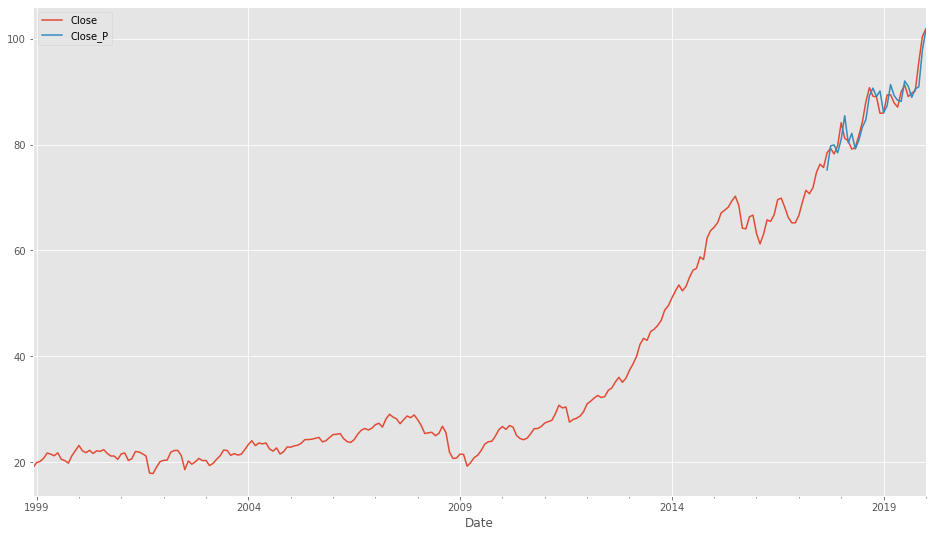

In [19]:
xlv_monthly_auto['Close_P'] = output_auto.predict(start = 225, end = 254, dynamic = False)
xlv_monthly_auto[['Close', 'Close_P']].plot(figsize = (16,9))
plt.legend(loc = 'upper left')
plt.show()


## 7) Forecasting Prices

Because we now have a model which we know will accurately fit our financial data, we can use the .get_forecast method (below) to obtain forecasted monthly closing price values for the next 3 years. We will also use the .conf_int() function to return a sort of buffer area around those values which represent the area that forecasted values can potentially fluctuate between with 95% certainty. 

In [31]:
future_dates.future_dates(xlv_monthly_auto)
prediction_auto = output_auto.get_forecast(steps = 36)
pred_conf_auto = prediction_auto.conf_int()

Finally, we can plot and visualize our forecasted closing price values. The Blue line represents our forecasted values and the purple represents the confidence interval within which it is realistic for the values to fall should they fluctuate from the path of the predicted blue line. We can see that the predicted closing prices of the XLV fund will continue to increase in the upcoming three years. 

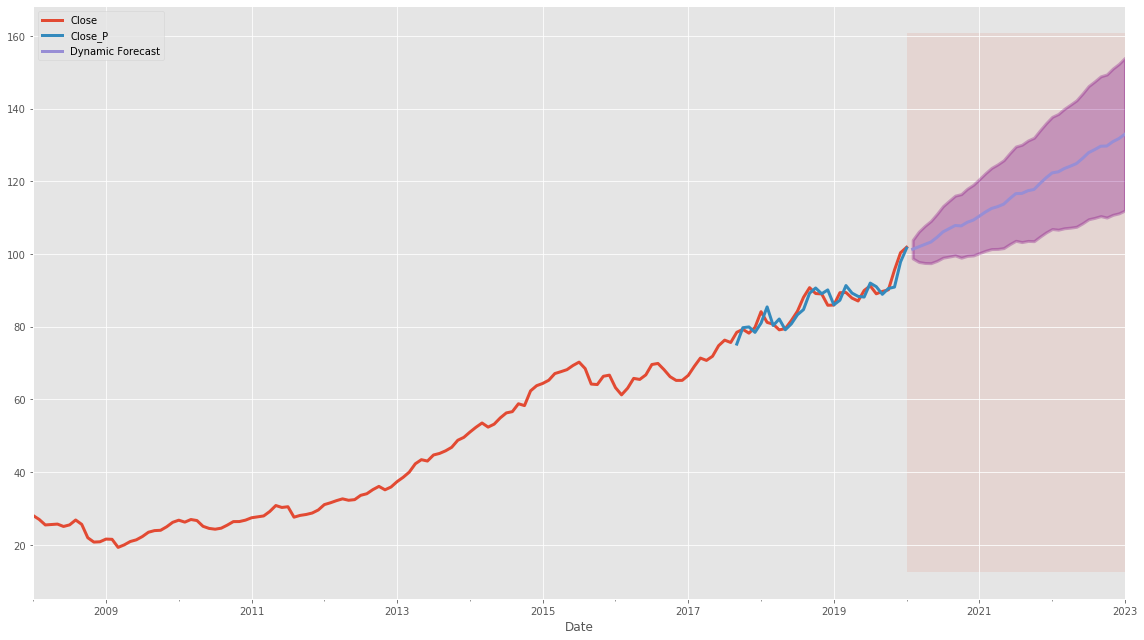

In [33]:
ax = xlv_monthly_auto['2008':].plot(label = 'Observed', figsize = (16,9), linewidth = 3)
prediction_auto.predicted_mean.plot(label = 'Dynamic Forecast', ax=ax, linewidth = 3)

ax.fill_between(pred_conf_auto.index,
                pred_conf_auto.iloc[:,0],
                pred_conf_auto.iloc[:,1], color = 'purple', alpha = .3, linewidth = 3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), pd.to_datetime('2024-01-01'), alpha=.1, zorder=-1)

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('Auto_ARIMA_Projection.png')
plt.show();